In [100]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [101]:
df_1y = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\UAL_1Y_CDS_prices.csv')
df_1y.rename(columns={'Date': 'date'}, inplace=True)
df_1y['date'] = pd.to_datetime(df_1y['date'])
df_1y.set_index('date', inplace=True)


#Need to get the full historicals for this
df_5y = pd.read_csv(r'C:\Users\LiamRodgers\OneDrive - stevens.edu\FE800\UAL Pricing Data\UAL 5Y CDS Pricing\UAL_5Y_CDS_2014FullData.csv') #Going to need more data for the 5 year CDS prices
df_5y.rename(columns={'Date': 'date', 'Last Price':'PX_LAST'}, inplace=True)
df_5y['date'] = pd.to_datetime(df_5y['date'])
df_5y.set_index('date', inplace=True)

df_10y = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\UAL_10Y_CDS_prices.csv')
df_10y.rename(columns={'Date': 'date'}, inplace=True)
df_10y['date'] = pd.to_datetime(df_10y['date'])
df_10y.set_index('date', inplace=True)

df_risk_free = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\risk_free_curve_2015.csv')
df_term_structure = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\CDS_term_structure_UAL.csv')

df_bond_price = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\UAL_hazard_rates.csv')
df_bond_price['date'] = pd.to_datetime(df_bond_price['date'])
df_bond_price = df_bond_price[['date', 'Time_to_Maturity', 'last_value', 'hazard']]
df_bond_price.set_index('date', inplace=True)

#Getting year end dates
Y1_end_date, Y5_end_date, Y10_end_date  = df_bond_price.index[-1], df_bond_price.index[-1], df_bond_price.index[-1]
Y1_start_date, Y5_start_date, Y10_start_date  = df_bond_price.index[0], df_bond_price.index[0], df_bond_price.index[0]


In [102]:
def Bond_CDS_matching(df1, df2):
    #df1 is the CDS data and df2 is the bond price data
    dates = df1.index.intersection(df2.index)
    df1 = df1.loc[dates]
    return df1

In [103]:
df_1y = Bond_CDS_matching(df_1y, df_bond_price)
df_5y = Bond_CDS_matching(df_5y, df_bond_price) #Data issue
df_10y = Bond_CDS_matching(df_10y, df_bond_price)

In [104]:
df_CDS_Bond = pd.merge(df_bond_price, df_1y, how = 'outer',left_index=True, right_index=True, suffixes=('_Bond', '_CDS'))
#Need to add year 5, but we have bad data
df_CDS_Bond = pd.merge(df_CDS_Bond, df_5y, how = 'outer',left_index=True, right_index=True, suffixes=('', '_CDS_5Y'))

df_CDS_Bond = pd.merge(df_CDS_Bond, df_10y, how = 'outer',left_index=True, right_index=True, suffixes=('', '_CDS_10Y'))
df_CDS_Bond.dropna(inplace=True)


In [105]:
from datetime import datetime, timedelta
from scipy.optimize import root_scalar

def generate_payment_dates(start_date, end_date, freq_months=3):
    """Return a list of quarterly payment dates from start_date to end_date."""
    pay_dates = []
    current_date = start_date
    while current_date < end_date:
        pay_dates.append(current_date)
        current_date += timedelta(days=(freq_months * 30.44))  # approximate month length
    pay_dates.append(end_date)
    return pay_dates

def get_discount_factor(df_risk_free, payment_date, obs_date):
    tenor = (payment_date - obs_date).days / 365.0
    # Interpolate risk-free rate using nearest available tenors
    match = df_risk_free.loc[np.abs(df_risk_free['tenor'] - tenor).idxmin()]
    rate = match['rate']
    discount = np.exp(-rate * tenor)
    return discount

def bootstrap_hazard(df_cds_series, payment_dates, df_risk_free, obs_date, recovery_rate):
    """
    Piecewise constant hazard rate bootstrapping for survival-based CDS pricing.
    df_cds_series: DataFrame with 'Date' (index) and 'PX_LAST'.
    payment_dates: dates for current tenor (quarterly)
    df_risk_free: risk-free curve DataFrame with 'tenor', 'rate' columns
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    """
    cds_spread = df_cds_series.loc[obs_date, 'PX_LAST'] / 10000  # convert bps to decimal
    f = 0.25  # quarterly payments

    N = len(payment_dates) - 1
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    # Objective: CDS pricing equation root in hazard h for this interval
    def cds_pricer(h):
        Q_local = [1.0]
        for i in range(N):
            dt = (payment_dates[i+1]-payment_dates[i]).days / 365.0
            Q_local.append(Q_local[-1]*np.exp(-h*dt))
        numer = sum([f * discounts[i] * (Q_local[i]-Q_local[i+1]) * (1-recovery_rate) for i in range(N)])
        denom = sum([f * discounts[i] * Q_local[i] for i in range(N)])
        return numer/denom - cds_spread
    # Solve for hazard rate
    sol = root_scalar(cds_pricer, bracket=[1e-6, 2.0], method='bisect')
    h_est = sol.root
    return h_est




In [106]:
#Usage:
bond_maturity = datetime(2026, 4, 11)
#I dont think we need this any more, because we are taking the bond hazard rates
payment_dates = generate_payment_dates(Y1_start_date, bond_maturity, 3)
h_1y = bootstrap_hazard(df_1y, payment_dates, df_risk_free, Y1_end_date, 0.4)
h_5y = bootstrap_hazard(df_5y, payment_dates, df_risk_free, Y5_end_date, 0.4)
h_10y = bootstrap_hazard(df_10y, payment_dates, df_risk_free, Y10_end_date, 0.4)
y1_bond_hazard = df_bond_price.loc[Y1_end_date, 'hazard']

# Repeat for 5Y and 10Y intervals, then stitch together to create piecewise hazard rate term structure.

In [107]:
def construct_survival_curve(payment_dates, hazard_rates, segment_starts):
    """
    Build survival probability Q(0,t) for each payment date using piecewise constant hazard rates.
    payment_dates: sorted list of payment dates (datetime)
    hazard_rates: list of hazard rates per segment (from bootstrapping for [0,1Y], [1Y,5Y], ...)
    segment_starts: list of start dates for each segment
    Returns: list of survival probabilities Q(0,t)
    """
    Q = [1.0]
    for i in range(1, len(payment_dates)):
        t = payment_dates[i]
        # Find the segment index
        for j in range(len(segment_starts)-1, -1, -1):
            if t >= segment_starts[j]:
                h = hazard_rates[j]
                t_prev = payment_dates[i-1]
                dt = (t - t_prev).days / 365.0
                Q.append(Q[-1] * np.exp(-h * dt))
                break
    return Q

def cds_par_spread(payment_dates, Q, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate survival-based par CDS spread for given payment dates and survival curve.
    payment_dates: list of CDS payment dates
    Q: survival probabilities for each payment date
    df_risk_free: DataFrame with risk-free curve
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    f: payment frequency (quarterly=0.25)
    """
    N = len(payment_dates) - 1 
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    numer = sum([f * discounts[i] * (Q[i]-Q[i+1]) * (1-recovery_rate) for i in range(N)])
    denom = sum([f * discounts[i] * Q[i] for i in range(N)])
    par_spread = numer / denom
    return par_spread

def bond_implied_cds(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate bond-implied CDS spread (BCDS) based on fitted bond survival curve Q_bond.
    Same calculation as cds_par_spread, but Q_bond from bond fitting.
    """
    return cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)

def cds_bond_basis(payment_dates, Q_bond, Q_cds, df_risk_free, obs_date, recovery_rate, market_cds_spread, f=0.25):
    """
    Compare bond-implied CDS (BCDS) to actual market CDS for given maturity.
    Returns: Curve Basis (BCDS - market CDS spread)
    """
    bcds = cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)
    curve_basis = bcds - market_cds_spread
    
    print(f"Market {market_cds_spread}\nBond-implied {bcds}\nCurve Basis: {curve_basis}")
    
    return curve_basis


In [108]:
#Calculating the CDS-Bond basis for each tenor interval using the bootstrapped hazard rates and survival curves.
# For example:
payment_dates_1y = generate_payment_dates(Y1_start_date, Y1_end_date, 3)
payment_dates_5y = generate_payment_dates(Y5_start_date, Y5_end_date, 3)
payment_dates_10y = generate_payment_dates(Y10_start_date, Y10_end_date, 3)

# Segments (start dates for each hazard rate interval):
segment_starts = [Y1_start_date, Y5_start_date, Y10_start_date]
hazard_rates = [h_1y, h_5y, h_10y]  # output from bootstrapping for each segment

# For all payment dates (combine the arrays as needed):
all_payment_dates = payment_dates_1y + payment_dates_5y[1:] + payment_dates_10y[1:]
survival_probs = construct_survival_curve(all_payment_dates, hazard_rates, segment_starts)


In [109]:
basis_series = []

for historical_date in df_CDS_Bond.index:
    # Get all hazard segment values for that date
    hazards_today = [
        df_CDS_Bond.loc[historical_date, 'hazard'],
        df_CDS_Bond.loc[historical_date, 'hazard'],
        df_CDS_Bond.loc[historical_date, 'hazard']
    ]
    segment_starts = [Y1_start_date, Y5_start_date, Y10_start_date]
    # Build the full term structure for all relevant payment dates
    Q_bond_full_today = construct_survival_curve(all_payment_dates, hazards_today, segment_starts)
    # Now slice Q and use the right section for each tenor!
    
    # 1Y
    Q_bond_1y = Q_bond_full_today[:len(payment_dates_1y)]
    bcds_1y_today = bond_implied_cds(payment_dates_1y, Q_bond_1y, df_risk_free, historical_date, 0.4)
    market_cds_1y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST'] / 10000
    basis_1y = bcds_1y_today - market_cds_1y_today

    # 5Y (similarly, slice Q for 5Y period)
    Q_bond_5y = Q_bond_full_today[:len(payment_dates_5y)]
    bcds_5y_today = bond_implied_cds(payment_dates_5y, Q_bond_5y, df_risk_free, historical_date, 0.4)
    market_cds_5y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_5Y'] / 10000
    basis_5y = bcds_5y_today - market_cds_5y_today

    # 10Y
    Q_bond_10y = Q_bond_full_today[:len(payment_dates_10y)]
    bcds_10y_today = bond_implied_cds(payment_dates_10y, Q_bond_10y, df_risk_free, historical_date, 0.4)
    market_cds_10y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_10Y'] / 10000
    basis_10y = bcds_10y_today - market_cds_10y_today

    # Store basis for all tenors for this date
    basis_series.append({
        'Date': historical_date,
        'CDS_Basis_1Y': basis_1y,
        'CDS_Basis_5Y': basis_5y,
        'CDS_Basis_10Y': basis_10y
    })

basis_df = pd.DataFrame(basis_series)
basis_df['Date'] = pd.to_datetime(basis_df['Date'])
for tenor in ['1Y', '5Y', '10Y']:
    basis_df[f'CDS_Basis_{tenor}'] = round(basis_df[f'CDS_Basis_{tenor}'], 3)


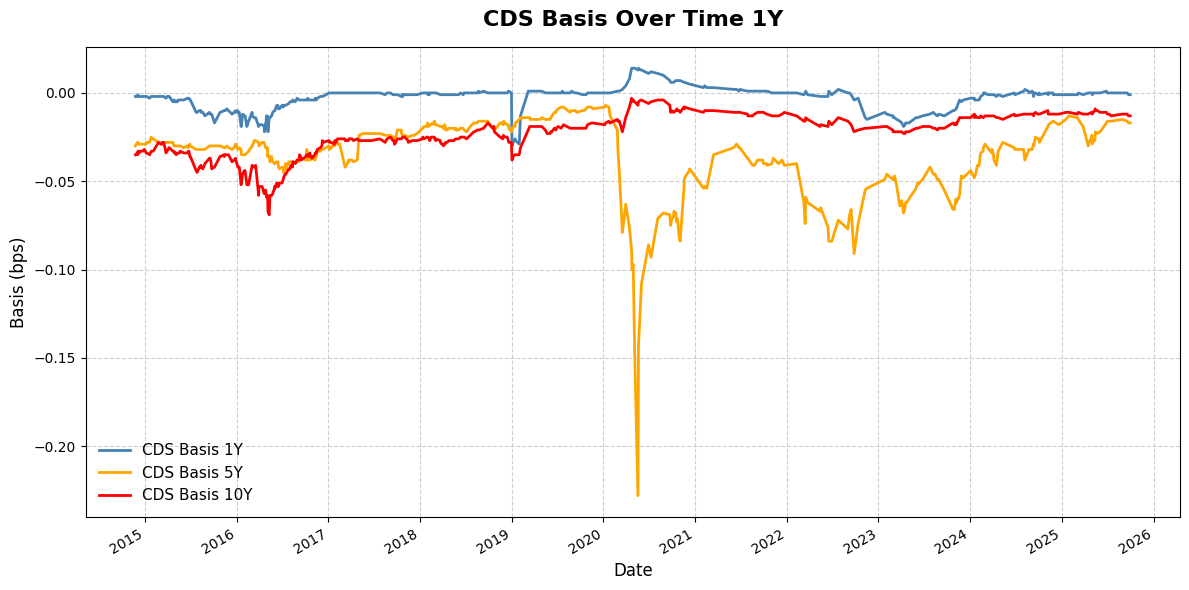

In [110]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))  # 12x6 inches is a good aspect ratio for reports
plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_1Y'],
    color='steelblue',
    linewidth=2,
    label='CDS Basis 1Y'
)
plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_5Y'],
    color='orange',
    linewidth=2,
    label='CDS Basis 5Y'
)

plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_10Y'],
    color='red',
    linewidth=2,
    label='CDS Basis 10Y'
)
# Title and labels
plt.title('CDS Basis Over Time 1Y', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Basis (bps)', fontsize=12)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # rotate date labels

# Add grid and legend
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.legend(frameon=False, fontsize=11)

# Clean up layout
plt.tight_layout()
plt.show()

In [111]:
#The longer tenors are fitting under the 0 basis because we have a flat curve (only one bond). In order to see the full curve we need to get more bonds from UAL
#to truly measure the risk of the longer tenor CDS spread, this is the limitation of the CDS structure that the longer tenor CDSs are typically underpriced